Image Classification Using CNNs
We are going to use the CIFAR-100 Dataset, to classify 100 classes of common items in full colour

1)In the next cell, import tensorflow, the required layers, etc

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
!pip install tensorflow-datasets

In [3]:
!pip install graphviz

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import graphviz
%matplotlib inline

2)In the next cell, clear any previous sessions

In [5]:
tf.keras.backend.clear_session()

3)In the next cell, set the following:
num_classes to the number of classes in CIFAR100
input_shape to the size of the input image required for EfficientNet (224x224x3)
batch_size to an appropriate number (you may need to adjust this based on the GPU/CPU you are using, start with 8 or 16)

In [6]:
num_classes = 100
input_shape = (224, 224, 3)
batch_size = 16

4)Create datasets
You will need to create 2 datasets here based on CIFAR100 (use tfds for this to make it easier)

train_ds containing 90% of the train dataset
val_ds containing the remaining 10% of the train dataset
test_ds containing the test dataset
Ensure that the data is shuffled, that you return the metadata (info) and that this is a supervised training activity

In [7]:
(train_ds, val_ds, test_ds), metadata = tfds.load('cifar100',
    split=['train[:90%]', 'train[90%:]', 'test'],
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/incomplete.VE0CIO_3.0.2/cifar100-train.tfrecord*...:   0%|       …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/incomplete.VE0CIO_3.0.2/cifar100-test.tfrecord*...:   0%|        …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


5)Use tfds.show_examples() to display samples from the train dataset

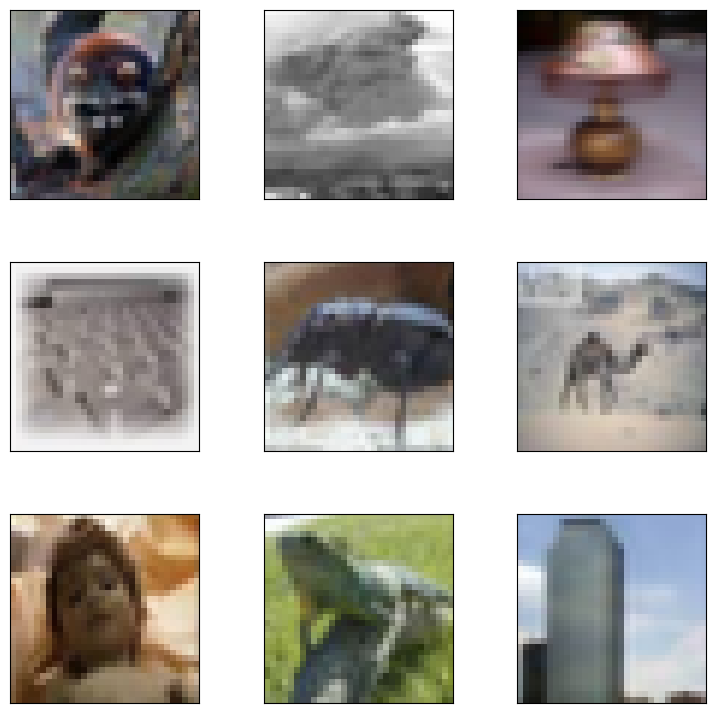

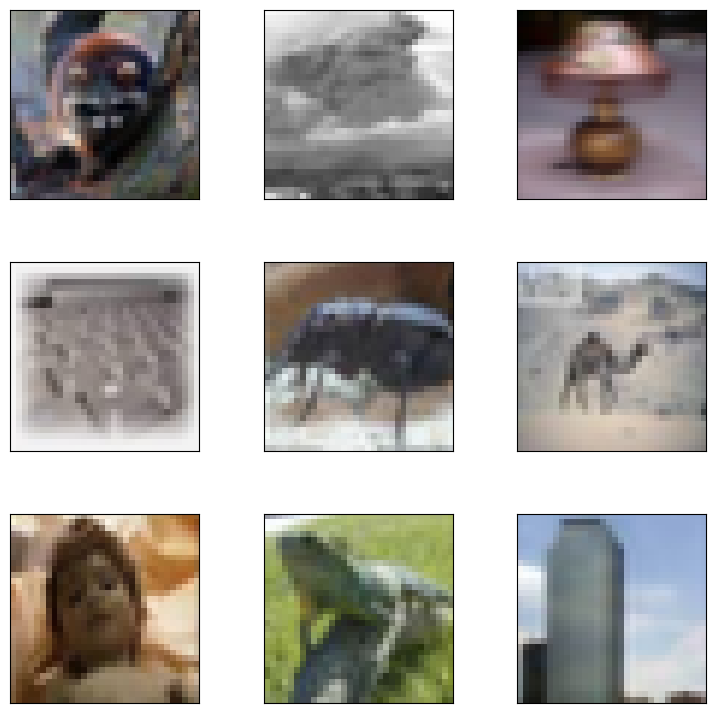

In [8]:
tfds.show_examples(train_ds, metadata)

6)Augmentation
Create a Sequential model for augmentation called data_augmentation in the following ways:

Resize the images to 224x224
Perform a random flip both horizontally and vertically
Perform a random rotation, starting with a value of 0.1
data_augmentation = 

In [9]:
data_augmentation = models.Sequential([
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1)
])

7)Create augmented dataset for train and val
For this, you will need to specify the batch size, for example train_ds.batch(batch_size)

In [10]:
aug_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)).batch(batch_size)
aug_val_ds = val_ds.map(lambda x, y: (data_augmentation(x), y)).batch(batch_size)

8)Building the Model
Create base_model with EfficientNetB0, ensuring that:

a)Weights are initialised with imagenet weights
b)The input shape is set correctly to the default for ImageNet / EfficientNetB0
c)The top classifier layer is not included

In [11]:
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


9)Create our Functional model for CIFAR100
You will need to create the following laters

An input layer with the input shape specified
The base_model (e.g. EfficientNetB0 defined above), ensuring this is set to training
A Global Average Pooling 2D layer
A Batch Normalization layer
A Dropout layer with dropout set to 50%
An output layer for the classifier with the correct number of neurons and activation function
Then create model using the correct parameters for model input and output layers and display the model summary


In [12]:
inputs = layers.Input(shape=input_shape)
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         128,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,182,791 (15.96 MB)

 Trainable params: 4,138,208 (15.79 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [13]:
import pydot

10) Plot the model, including the layers of EfficientNetB0

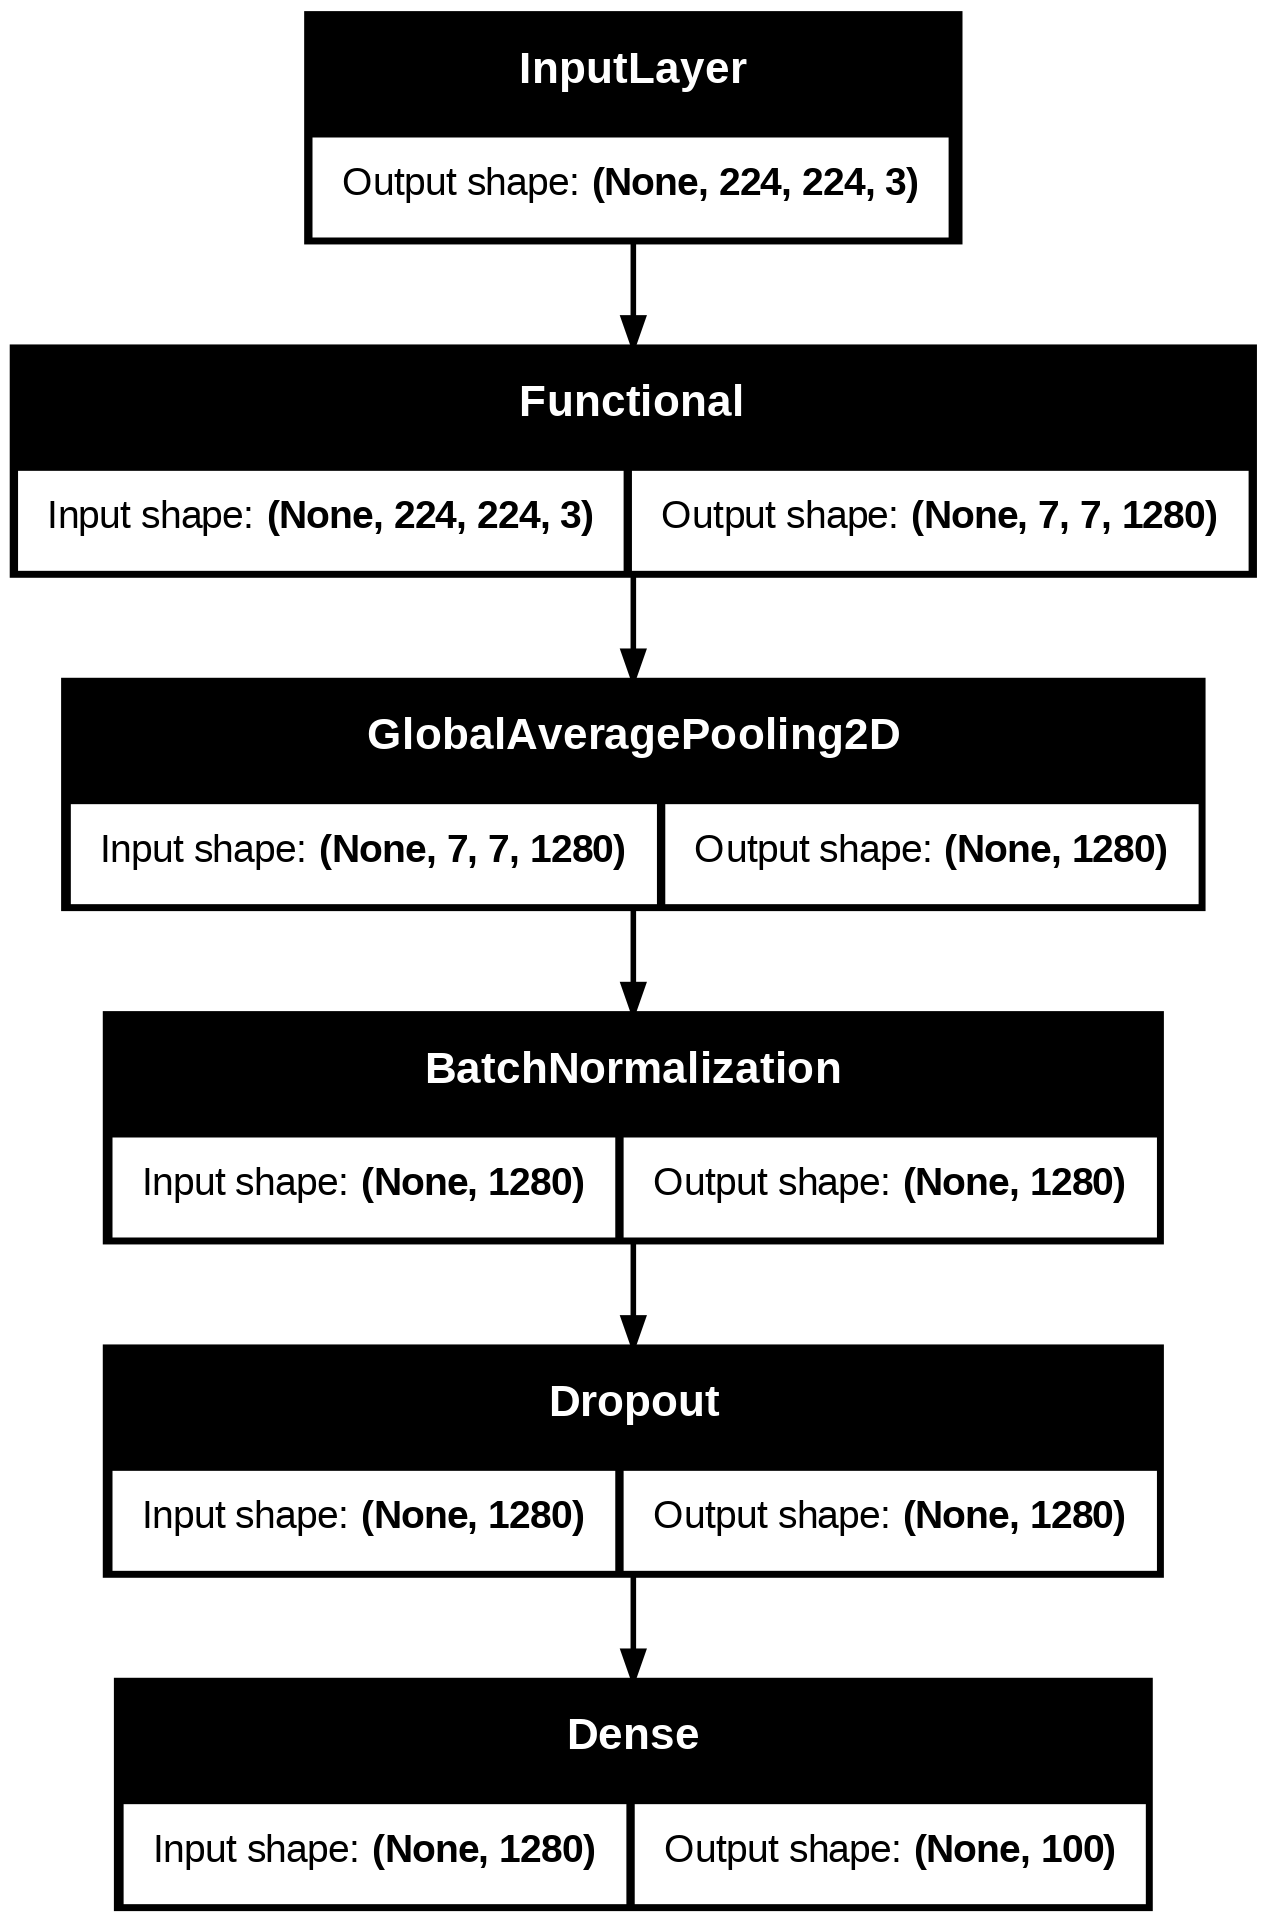

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True)


Create callbacks
a)You can optionally create an early stopping callback, but for the initial run let the model train to completion
b)Create a Reduce On Plateau callback that monitors the validaiton loss, sets mode to min, patience of 5, factor of 0.5 and a minimum learning rate of 1e-6. Setting verbose to 1 provides useful information during training


In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

12)Compile the model
a)Use the Adam optimizer with an initial learning rate of 1e-4
b)Set loss correctly for a multi-class classifier
c)For metrics, use accuracy

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

13)Train the model
Train the model using the following parameters

a)Augmented training and validation datasets
b)15 epochs
c)The correct batch size
d)At a minimum, the reduce on plateau callback
Record the training history so you can view it later

In [17]:
history = model.fit(
    aug_train_ds,
    validation_data=aug_val_ds,
    epochs=15,
    callbacks=[reduce_on_plateau])

Epoch 1/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 754s 240ms/step - accuracy: 0.1643 - loss: 4.2070 - val_accuracy: 0.6198 - val_loss: 1.3640 - learning_rate: 1.0000e-04
Epoch 2/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 595s 204ms/step - accuracy: 0.5038 - loss: 1.8916 - val_accuracy: 0.6912 - val_loss: 1.0915 - learning_rate: 1.0000e-04
Epoch 3/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 627s 206ms/step - accuracy: 0.6089 - loss: 1.4166 - val_accuracy: 0.7300 - val_loss: 0.9833 - learning_rate: 1.0000e-04
Epoch 4/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 620s 220ms/step - accuracy: 0.6715 - loss: 1.1510 - val_accuracy: 0.7526 - val_loss: 0.8901 - learning_rate: 1.0000e-04
Epoch 5/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 591s 210ms/step - accuracy: 0.7203 - loss: 0.9571 - val_accuracy: 0.7582 - val_loss: 0.8671 - learning_rate: 1.0000e-04
Epoch 6/15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 661s 224ms/step - accuracy: 0.7547 - loss: 0.8251 - val_accuracy: 0.7688 - val_loss: 0.8415 - learning_rate: 1.0000e-04
Epoch 7/15
2813/2813 ━━━━━━━

4)Model evaluation
To evaluate the model, perform the following steps:
Create an augmentation sequential network to resize the images only
Create an augmented test dataset with the images set to the correct size, and with the correct batch size set

In [18]:
resize_data_augmentation = models.Sequential([
    layers.Resizing(224, 224)
])

15)Now evaluate the model on the resized test dataset

In [19]:
resized_test_ds = test_ds.map(lambda x, y: (resize_data_augmentation(x), y)).batch(batch_size)

In [20]:
loss_test, accuracy_test = model.evaluate(resized_test_ds)
print(f"Test accuracy: {accuracy_test:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8065 - loss: 0.8495
Test accuracy: 0.8092


16)Now save the model using model.save()

In [22]:
model.save('cifar100_efficientnet_pmc.keras')